# RNN Pilot Implementation DEMO

# Importing libraries

Mounting Google Drive to our Shared EmotionDetectionProject folder

In [10]:
from google.colab import drive
drive.mount("/content/drive")
#audio_path="/content/drive/MyDrive/RAVDESS/archive/{}/"
audio_path="/content/drive/MyDrive/EmotionDetectionProject/Datasets/RAVDESS/{}/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=2efd0f40fee7f39b80622f552300f80c136aaa9521878f1de9d89949be982f32
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features


In [11]:
#Feature Extraction part
import pandas as pd
import numpy as np
import os
import librosa
from python_speech_features import mfcc
import xarray as xr

#RNN part
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, ConvLSTM2D,BatchNormalization
from keras.layers.convolutional import Conv3D
from sklearn.preprocessing import OneHotEncoder
from keras.utils import plot_model

tf.__version__

'2.9.2'

# Extracting names & labels of audio files

In [12]:
def classes():
  labels=[]
  for j in range(1,25):
    path=audio_path.format("Actor_"+"{:0>2d}".format(j))
    for i in os.listdir(path):
      lab=i.split('-')[2]
      labels.append(lab)
  return labels

#Extracts the name of the samples
def get_names():
  names=[]
  for i in range(1,25):
    path=audio_path.format("Actor_"+"{:0>2d}".format(i))
    for j in os.listdir(path):
      names.append(j)
  return names

In [13]:
# extracting the names and labels
names=get_names()
labels=classes()

# Feature Extraction

In [14]:
def extract_all_features(audio_file,n,rate):
  data=[]
  X, sample_rate = librosa.load(audio_file,sr=rate, duration=2.5, offset=0.4)
  rmse= librosa.feature.rms(X)[0]
  spectral_centroid = librosa.feature.spectral_centroid(X)[0]
  spectral_bandwidth= librosa.feature.spectral_bandwidth(X)[0]
  spectral_rolloff = librosa.feature.spectral_rolloff(X)[0]
  spectral_contrast = librosa.feature.spectral_contrast(X)[0]
  spectral_flatness = librosa.feature.spectral_flatness(X)[0]
  chroma_stft = librosa.feature.chroma_stft(X)[0]
  chroma_cqt = librosa.feature.chroma_cqt(X)[0]
  chroma_cens = librosa.feature.chroma_cens(X)[0]
  zero_crossing = librosa.feature.zero_crossing_rate(X, frame_length=2048)[0]
  MFCCs = librosa.feature.mfcc(y=X, sr=rate, n_mfcc=n)
  tonnetz = librosa.feature.tonnetz(X)[0]
  data.extend([rmse,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing,tonnetz,chroma_stft,chroma_cqt,chroma_cens])
  data.extend([i for i in MFCCs])
  return data


In [15]:
# array=[]

# def extract3d(g,n,sr,x):
#   path=g
#   actor="Actor_"+"{:0>2d}".format(x)
#   for i in os.listdir(g):
#     l=extract_all_features(path+i,n,sr)
#     array.append(l)

# #Extracting 
# for i in range(1,25):
#   extract3d(audio_path.format("Actor_"+"{:0>2d}".format(i)),21,48000,i)


KeyboardInterrupt: ignored

In [16]:
features=["rmse","spectral_centroid","spectral_bandwidth","spectral_rolloff","zero_crossing","tonnetz","chroma_stft","chroma_cqt","chroma_cens"]
features.extend(["MFCC"+str(i+1) for i in range(21)])

In [17]:
# double checking the dimensions
print(len(array),len(array[0]),len(array[0][0])) 

980 30 235


In [18]:
# data = xr.DataArray(array,coords={'Sample': names,'Feature': features,'Values': range(235)},dims=('Sample', 'Feature', 'Values'))
# print("Audio File: ",names[0], "\nClass is: ", labels[0])
# data[0]

ValueError: ignored

In [ ]:
# np.save("3D-All_Features_Data-np",data)

In [ ]:
# data.to_netcdf("3D-All_Features_Data.nc")

# Loading 3D array and labels


In [19]:
data = np.load('/content/drive/MyDrive/EmotionDetectionProject/Datasets/3D-Data-np.npy')

In [20]:
labels= np.load('/content/drive/MyDrive/EmotionDetectionProject/Datasets/3D-Data-Labels.npy')

Train test split

In [21]:
X_train = data[:1000, :, :]
X_test = data[1000:, :, :]

In [22]:
y_train= labels[:1000]
y_test= labels[1000:]

In [23]:
X_train=np.reshape(X_train,(1000,235,20))
X_test=np.reshape(X_test,(440,235,20))

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 235, 20)
(440, 235, 20)
(1000,)
(440,)


In [25]:
y_train=np.asarray([int(i) for i in y_train ])
y_test=np.asarray([int(i) for i in y_test])
y_train = y_train.reshape(-1, 1)
y_test= y_test.reshape(-1, 1)


One hot encoding the labels

In [26]:
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)
y_train = y_train.toarray()
y_test = y_test.toarray()

# LSTM Implementation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                21760     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 34,760
Trainable params: 34,760
Non-traina

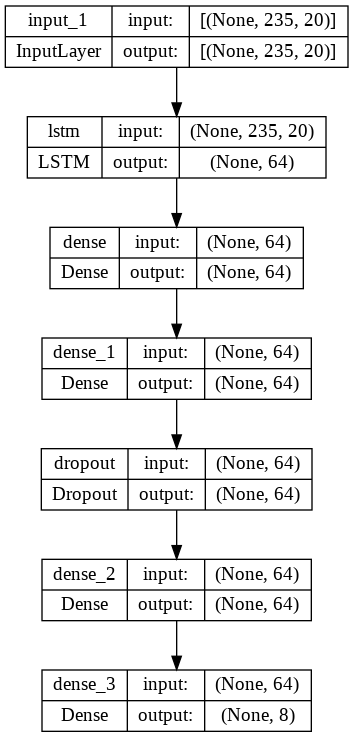

In [27]:
model = Sequential()

model.add(layers.Input(shape = (235, 20)))

# Recurrent layer
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(8, activation='softmax'))

print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
history = model.fit(X_train, y_train, epochs=24, verbose=2)

Epoch 1/24
32/32 - 12s - loss: 2.0907 - accuracy: 0.1330 - 12s/epoch - 384ms/step
Epoch 2/24
32/32 - 8s - loss: 2.0648 - accuracy: 0.1570 - 8s/epoch - 251ms/step
Epoch 3/24
32/32 - 8s - loss: 2.0623 - accuracy: 0.1490 - 8s/epoch - 246ms/step
Epoch 4/24
32/32 - 8s - loss: 2.0553 - accuracy: 0.1790 - 8s/epoch - 245ms/step
Epoch 5/24
32/32 - 8s - loss: 2.0504 - accuracy: 0.1690 - 8s/epoch - 247ms/step
Epoch 6/24
32/32 - 12s - loss: 2.0327 - accuracy: 0.2030 - 12s/epoch - 378ms/step
Epoch 7/24
32/32 - 8s - loss: 2.0247 - accuracy: 0.1840 - 8s/epoch - 250ms/step
Epoch 8/24
32/32 - 8s - loss: 2.0098 - accuracy: 0.2020 - 8s/epoch - 249ms/step
Epoch 9/24
32/32 - 8s - loss: 1.9904 - accuracy: 0.2360 - 8s/epoch - 252ms/step
Epoch 10/24
32/32 - 8s - loss: 1.9707 - accuracy: 0.2250 - 8s/epoch - 255ms/step
Epoch 11/24
32/32 - 10s - loss: 1.9540 - accuracy: 0.2390 - 10s/epoch - 316ms/step
Epoch 12/24
32/32 - 8s - loss: 1.9243 - accuracy: 0.2700 - 8s/epoch - 251ms/step
Epoch 13/24
32/32 - 8s - loss: 

In [30]:
results = model.evaluate(X_test, y_test, batch_size=1)
print("test loss, test acc:", results)

440/440 [==============================] - 11s 24ms/step - loss: 2.6270 - accuracy: 0.1227
test loss, test acc: [2.627025842666626, 0.12272727489471436]
